# Import Modules

In [1]:
import sys
import time
from dataclasses import dataclass
import random as r
import numpy as np
from functools import partial
from matplotlib import pyplot as plt
from sentencepiece import SentencePieceProcessor
import os; import glob
import requests
from typing import Callable, Sequence, Any, Optional
import functools; import operator
from tqdm import tqdm
import pickle

import jax
from jax import (
    Array,
    numpy as jnp,
    random as jrand
)
try:
    from flash_attn_jax import flash_mha
    USE_FLASH_ATT = True
except:
    USE_FLASH_ATT = False
import keras as nn; nn.utils.set_random_seed(42)
nn.mixed_precision.set_dtype_policy("mixed_bfloat16")
import torch

print("Python Version", sys.version); del sys
print(f"Keras Version {nn.__version__} with {nn.backend.backend()} backend \tJax Version {jax.__version__}")
print("Jax backend device", jax.default_backend())

Python Version 3.11.8 (main, Feb 25 2024, 16:39:33) [GCC 11.4.0]
Keras Version 3.0.4 with jax backend 	Jax Version 0.4.23
Jax backend device gpu


# Tokenizer

In [2]:
tokenizer_path = "sentence_piece_32000.model"
spm = SentencePieceProcessor(model_file=tokenizer_path)
VOCAB_SIZE = spm.vocab_size(); print(VOCAB_SIZE)
SOS = spm.bos_id()
print(spm.Decode(spm.Encode("Hey hi!!!")), spm.Encode("Hey hi!!!"))

32000
Hey hi!!! [18637, 7251, 21004]


# Dataset

In [3]:
DATA_CACHE_DIR = "data/TinyStories"
TRAIN_FILE_PATH = os.path.join(DATA_CACHE_DIR, "train.txt")
VAL_FILE_PATH = os.path.join(DATA_CACHE_DIR, "val.txt")

SHARD_DIR = os.path.join(DATA_CACHE_DIR, f"tok{VOCAB_SIZE}")

## File Utils

In [4]:
def download_file(url:str, filename:str, chunk_size:int=1024):
    """Download a file from the given URL and save it with the specified filename"""
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get("content-length", 0))
    with open(filename, "wb") as file, tqdm(
        desc=filename,
        total=total,
        unit="iB",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

    print(f"{filename} downloaded successfully:")

## Data

In [5]:
def download():
    "download if train file not present and data dir is empty"
    os.makedirs(DATA_CACHE_DIR, exist_ok=True)

    urls = ["https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-train.txt",
            "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-valid.txt"]
    file_paths = [TRAIN_FILE_PATH, VAL_FILE_PATH]

    if (not os.listdir(DATA_CACHE_DIR)):
        # download files
        for url, file_path in zip(urls, file_paths):
            if (not os.path.exists(file_path)):
                download_file(url, file_path)
    else:
        print(f"{file_paths[0]} is present. Skipping download.")

In [6]:
download() # ~8mins to download

data/TinyStories/train.txt is present. Skipping download.


## Pretokenize, Shard and Load Data Functions

In [7]:
def pretokenize_and_save_dataset(train_ds_path:str, val_ds_path:str, num_shards:int):
    if glob.glob(os.path.join(SHARD_DIR, "*.npy")):
        print("Dataset is already pretokenized.")
    else:
        print("Pretokenizing dataset...")
        dataset = open(train_ds_path, "r", encoding="utf-8").read().split("<|endoftext|>")
        val_dataset = open(val_ds_path, "r", encoding="utf-8").read().split("<|endoftext|>")

        dataset = dataset + val_dataset; del val_dataset
        dataset = list(map(str.strip, dataset))
        dataset:list = spm.Encode(
                dataset,
                add_bos=True,
                add_eos=False
            ) # [[SOS story], ..., [SOS story]]
        print("Dataset:")
        print("\tNumber of stories:", len(dataset))

        # flatten
        dataset = functools.reduce(operator.iconcat, dataset, [])
        num_tokens = len(dataset); print("\tNumber of tokens in the dataset:", num_tokens)
        print("\tNumber of unique tokens in the dataset:", len(set(dataset)))
        
        dataset = np.asarray(dataset, dtype=np.uint16) # [SOS story ... SOS story]
        print("\tAvg length of story:", num_tokens/((dataset==SOS).sum()))

        # shard and save dataset
        sharded_datasets_list = np.array_split(dataset, num_shards) # [[SOS story...], [...], [...], ...]
        filenames = [os.path.join(SHARD_DIR, f"shard{i+1}.npy") for i in range(num_shards)]
        
        for filename, sharded_ds in tqdm(zip(filenames, sharded_datasets_list), total=len(filenames), desc="Saving pretokenized shards"):
            with open(filename, "wb") as f:
                np.save(f, sharded_ds)
        print("Done.")


class IterDataset(torch.utils.data.IterableDataset):
    def __init__(self, split:str, maxlen:int, seed:int=42):
        self.split = split
        self.maxlen = maxlen
        
        os.makedirs(SHARD_DIR, exist_ok=True)
        self.shard_filepaths = glob.glob(os.path.join(SHARD_DIR, "*.npy"))
        self.r = r.Random(seed)

    def __iter__(self):
        split_shard_filepaths = self.shard_filepaths[:-1] if self.split == "train" else self.shard_filepaths

        while True:
            self.r.shuffle(split_shard_filepaths)
            for shard in split_shard_filepaths:
                m:np.ndarray = np.load(shard, mmap_mode="r")

                num_batches = len(m)//self.maxlen
                num_batches -= 1 # drop remainder
                assert num_batches > 0, "Number of batches should be greater than 0. Investigate..."

                ixs = list(range(num_batches))
                self.r.shuffle(ixs)

                for ix in ixs:
                    start = ix*self.maxlen
                    end = start + self.maxlen + 1

                    chunk = torch.from_numpy(m[start:end].astype(dtype=np.int64))
                    x = chunk[:-1]
                    y = chunk[1:]
                    yield x, y


class BatchedDataset:
    @staticmethod
    def iter_ds(batch_size, device, num_workers=0, **ds_kwargs):
        ds = torch.utils.data.DataLoader(
            IterDataset(**ds_kwargs), batch_size=batch_size, pin_memory=True,
            num_workers=num_workers
        )

        for x, y in ds:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            yield x, y

# GPT

## Positional Embeddings

In [8]:
class PositionalEmbedding:
    """```
    Sinusoidal Fixed Positional Embeddings
    Args:
        maxlen:int
        dim:int
    sinusoidal_embeddings: 
        pos_emb: (1, maxlen, dim)
    get_freqs:
        get_freqs: sin_freqs(1, maxlen, 1, dim), cos_freqs(1, maxlen, 1, dim)
    ```"""
    def __init__(self, maxlen:int, dim:int):
        p, i = jnp.meshgrid(jnp.arange(float(maxlen)), jnp.arange(dim/2)*2)
        theta = (p/1e4**(i/dim)).T
    
        self.pos_emb = jnp.stack([jnp.sin(theta), jnp.cos(theta)], axis=-1)
        self.pos_emb = self.pos_emb.reshape((maxlen, dim))[None] # (1, maxlen, dim)
    
    def sinusoidal_embeddings(self):
        return self.pos_emb # (1, maxlen, dim)
    
    def get_freqs(self):
        sin_freqs = self.pos_emb[..., None, ::2].repeat(2, axis=-1)
        cos_freqs = self.pos_emb[..., None, 1::2].repeat(2, axis=-1)
        return sin_freqs, cos_freqs # (1, maxlen, 1, dim), (1, maxlen, 1, dim)

## Attention

In [9]:
class Attention(nn.Layer):
    """```
    Multi-head Attention
    Args:
        causal:bool
        config
    Input:
        x: shape(B, N, d_model)
        training: bool
    Output:
        linear_att_out: shape(B, N, d_model)
    ```"""
    def __init__(
            self,
            causal:bool,
            config,
            **kwargs
    ):
        super().__init__(**kwargs)
        assert config.d_model % config.num_heads == 0
        self.flash = config.use_flash_att
        self.causal = causal
        self.num_heads = config.num_heads
        self.dim = config.d_model//config.num_heads

        self.wq = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.wk = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.wv = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.dropout = nn.layers.Dropout(config.dropout_rate)

        self.wo = nn.layers.Dense(
            config.d_model,
            use_bias=config.use_bias,
            kernel_initializer=config.intializer(std=0.02/(2*config.num_layers)**0.5)
        )
        if causal and (not config.use_flash_att): # when causal and not using flash att
            self.causal_mask = jnp.triu(jnp.full(shape=(1, 1, config.maxlen, config.maxlen), fill_value=-jnp.inf), k=1)

    def call(
            self,
            x:Array, # (B, T, d_model)
            training:bool
    ):
        B, T, d_model = x.shape

        # compute q, k, v
        q = self.wq(x) # (B, T, d_model)
        k = self.wk(x) # (B, T, d_model)
        v = self.wv(x) # (B, T, d_model)
        
        # compute attention weights
        if self.flash:
            shape = (B, T, self.num_heads, self.dim)
            q, k, v = q.reshape(shape), k.reshape(shape), v.reshape(shape) # (B, T, h, dim)
            att_out = flash_mha(q, k, v, softmax_scale=None, is_causal=self.causal) # (B, T, h, dim)
        else:
            shape = (B, self.num_heads, T, self.dim)
            q, k, v = q.reshape(shape), k.reshape(shape), v.reshape(shape) # (B, h, T, dim)
            att_wei = (q @ jnp.matrix_transpose(k))/self.dim**0.5 # (B, h, T, T) <= (B, h, T, dim) @ (B, h, T, dim).transpose(2, 3)
            # causal mask
            if self.causal:
                att_wei += self.causal_mask[:, :, :T, :T] # (B, h, T, T)
            att_wei = jax.nn.softmax(att_wei, axis=-1) # (B, h, T, T)
            # apply attention weights to v
            att_out = att_wei @ v # (B, h, T, T) @ (B, h, T, dv) => (B, h, T, dv)

        # combine heads
        att_out = att_out.reshape((B, T, d_model)) # (B, T, h*dim) ==> (B, T, d_model)

        # linear of att_out
        linear_att_out = self.wo(att_out)
        linear_att_out = self.dropout(linear_att_out, training=training) # (B, T, d_model)
        return linear_att_out

## Block

In [10]:
class TransformerBlock(nn.Model):
    """```
    TransformerBlock
    Args:
        causal:bool
        config
    Inputs:
        inputs: shape(B, T, d_model)
        pad_mask: shape(B, T) of boolean dtype
    Outputs:
        outputs: shape(B, T, d_model)
    ```"""
    def __init__(
            self, 
            causal:bool, 
            config,
            **kwargs
    ):
        super().__init__(**kwargs)
        dff_in = 4*config.d_model
        self.norm1 = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        self.mha = Attention(causal, config)

        self.ffn = nn.Sequential([
            nn.layers.Dense(int(dff_in), use_bias=config.use_bias, kernel_initializer=config.intializer(std=0.02)),
            nn.layers.Activation(lambda x: nn.activations.gelu(x, approximate=True)),
            nn.layers.Dense(config.d_model, use_bias=config.use_bias, kernel_initializer=config.intializer(std=0.02)),
            nn.layers.Dropout(config.dropout_rate)
        ])
        self.norm2 = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        
    def call(self, x:Array, training:bool):
        z = x + self.mha(self.norm1(x), training=training)
        y = z + self.ffn(self.norm2(z), training=training)
        return y # (B, T, d_model)

In [11]:
def build_model(model:nn.Model, input_shape:tuple, val_intervals:tuple):
    blabla = model(
        jrand.randint(jrand.PRNGKey(32344), shape=input_shape, minval=val_intervals[0], maxval=val_intervals[-1]), training=True
    ); del blabla
    return model

class TieWeights(nn.Layer):
    def __init__(self, Layer:nn.Layer, bias_units:int|None, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.Layer = Layer # weights of (1, vocab_size, d_model)
        self.use_bias = bool(bias_units)
        self.activation = nn.layers.Activation(nn.activations.get(activation), dtype=kwargs["dtype"])
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(bias_units,), initializer="zeros", trainable=True)
        
    def call(self, x): # (B, T, d_model)
        W = jnp.array(self.Layer.weights)[0] # (vocab_size, d_model)
        z = x @ jnp.matrix_transpose(W) # (B, T, vocab_size)
        if self.use_bias:
            z += self.bias
        return self.activation(z)

## Transformer

In [12]:
class Transformer(nn.Model):
    """```
    Decoder Transformer!!
    Args:
        causal:bool
        config:
            d_model: int
            num_heads: int
            num_layers: int
            maxlen: int
            vocab_size: int
            output_units: int => if None is equal to vocab_size
            use_bias:bool,
            dropout_rate: float
        output_activation:str
    Inputs:
        inputs: shape(B, T)
    Outputs: 
        outputs: shape(B, T, d_model)    
    ```"""
    def __init__(self, causal:bool, config, output_activation:str=None, **kwargs):
        super().__init__(**kwargs)
        if config.output_units is None:
            config.output_units = config.vocab_size
        # pos embedding
        self.pos_embed = PositionalEmbedding(config.maxlen, config.d_model).sinusoidal_embeddings() # (1, maxlen, d_model)
        # embedding tokens and dropout
        self.emb_dropout = nn.layers.Dropout(config.dropout_rate)
        self.token_embed = nn.layers.Embedding(
            config.vocab_size,
            config.d_model,
            embeddings_initializer=config.intializer(std=0.02)
        )

        # block layers
        self.block_layers = [
                TransformerBlock(
                    causal=causal, 
                    config=config
                ) for _ in range(config.num_layers)
            ]

        # final layer: outputs logits with dropout
        self.norm = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        
        self.linear = TieWeights(
            self.token_embed,
            bias_units=None if config.use_bias is False else config.output_units,
            activation=output_activation,
            dtype="float32"
        )

    def call(
            self, 
            inputs:Array,
            training=False
    ):
        # embed tokens
        x = self.emb_dropout(
            self.token_embed(inputs)+self.pos_embed[:, :inputs.shape[-1], :], training=training
        ) # (B, T) ==> (B, T, d_model) # (B, T) ==> (B, T, d_model)
        
        # block layers
        for layer in self.block_layers:
            x = layer(x, training=training) # (B, T, d_model) ==> (B, T, d_model)
        x = self.norm(x)

        # linear layer: outputs logits
        logits = self.linear(x) # (B, T, d_model) ==> (B, T, vocab_size)
        return logits

# GPT Configuration

In [13]:
@dataclass
class GPTConfig:
    """GPT 15M Configuration"""
    use_flash_att:bool=USE_FLASH_ATT
    d_model:int = 288
    num_layers:int = 6
    num_heads:int = 6
    maxlen:int = 256
    vocab_size:int = VOCAB_SIZE
    output_units:int = None
    assert d_model % 2 == 0
    assert d_model % num_heads == 0
    dropout_rate:float = 0.0
    use_bias:bool = True
    intializer:Callable = lambda std: nn.initializers.RandomNormal(mean=0.0, stddev=std)

GPTConfig()

GPTConfig(use_flash_att=True, d_model=288, num_layers=6, num_heads=6, maxlen=256, vocab_size=32000, output_units=None, dropout_rate=0.0, use_bias=True, intializer=<function GPTConfig.<lambda> at 0x7ed1fd0d0680>)

# Loss vs Learning Rate

```python
def LossvsLR(): # (B, maxlen)
    model = build_model(
        Transformer(causal=True, config=GPTArgs), 
        (2, GPTArgs.max_context_length), 
        (0, GPTArgs.vocab_size-1)
        )
    inputs = jrand.randint(jrand.PRNGKey(32344), shape=(2, GPTArgs.max_context_length+1), minval=0, maxval=GPTArgs.vocab_size-1)

    def get_loss(lr, model, inputs):
        x, y = inputs[:, :-1], inputs[:, 1:]
        model.compile(
            optimizer=nn.optimizers.AdamW(
                learning_rate=lr, beta_1=0.9, beta_2=0.95, clipvalue=1e0, weight_decay=1e-1),
            loss=nn.losses.SparseCategoricalCrossentropy(from_logits=True)
        )
        loss = model.train_on_batch(x=x, y=y)
        return loss.tolist()
    
    lrs = (10**jnp.linspace(-6, -2, 100)).tolist()
    losses = [get_loss(lr, model, inputs) for lr in lrs]
    # losses = jax.vmap(get_loss, in_axes=(None, 0))(model, lrs)
    return lrs, losses

lr, loss = LossvsLR()

plt.figure(figsize=(15,5))
plt.xlabel("Log base10 Learning Rate: Do 10^(x) to get actual learning rate")
plt.ylabel("Loss")
plt.xticks([-6, -5, -4]+jnp.arange(-3.5, -2.0, 0.1).tolist())
plt.plot(jnp.log10(jnp.array(lr)), loss)
plt.show()
# gonna set 5e-4 as minimum learning rate, log(5e-4)=−3.301029996 from graph
```
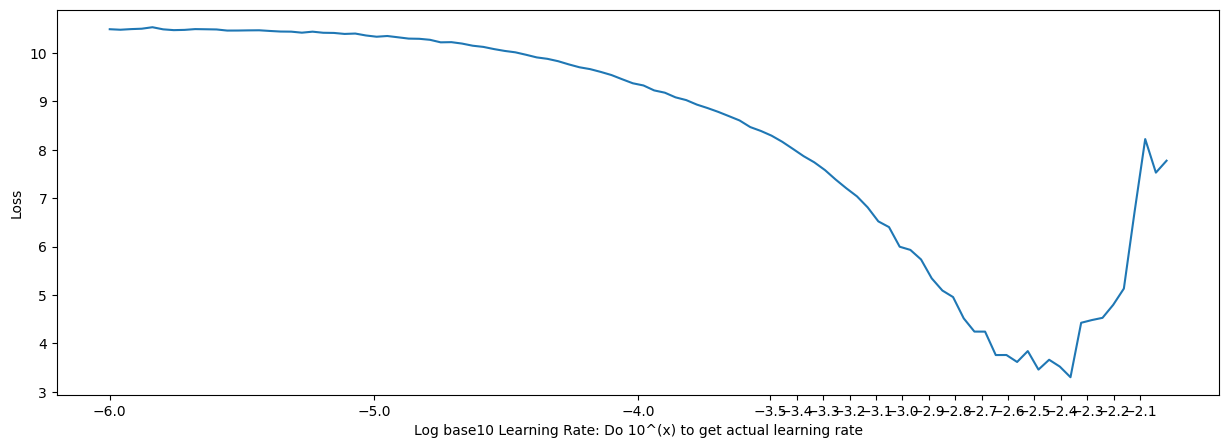

```python
>>>10**jnp.arange(-3.5, -2.0, 0.1), jnp.arange(-3.5, -2.0, 0.1)
(Array([0.00031623, 0.00039811, 0.00050119, 0.00063096, 0.00079433,
        0.001     , 0.00125892, 0.00158489, 0.00199526, 0.00251188,
        0.00316227, 0.00398106, 0.00501186, 0.00630956, 0.00794326],      dtype=float32),
 Array([-3.5      , -3.4      , -3.3000002, -3.2000003, -3.1000004,
        -3.0000005, -2.9000006, -2.8000007, -2.7000008, -2.6000009,
        -2.500001 , -2.400001 , -2.3000011, -2.2000012, -2.1000013],      dtype=float32))
```

# Training Arguments

In [14]:
@dataclass
class TArgs:
    batch_size:int = 128 # micro-mini-batch_size if num_grad_accumalation_steps > 1
    num_grad_accumalation_steps:int = 4
    ## num_tok_per_update = batch_size * maxlen * gradient_accumalation = 128 * 256 * 4 = 131_072

    # lr scheduler
    init_lr:float = 1e-7
    max_lr:float = 5e-4
    min_lr:float = 0.0*max_lr # The factor is usually 0.1 or 0.0
    num_steps:int = 100_000
    warmup_steps:int = 1000
    decay_steps:int = num_steps

    # optimizer
    beta1:float = 0.9
    beta2:float = 0.95
    weight_decay:float = 1e-1
    clipnorm:float = 1e0

    # training
    resume_from_checkpoint:Optional[str] = None
    return_best_train_states:bool = True
    checkpoint_dir:str = "ckpt/stories32000"
    eval_freq:int = 2000
    eval_steps:int = 100
    patience:int = 15 # early stopping with restore best weights

TArgs()

TArgs(batch_size=128, num_grad_accumalation_steps=4, init_lr=1e-07, max_lr=0.0005, min_lr=0.0, num_steps=100000, warmup_steps=1000, decay_steps=100000, beta1=0.9, beta2=0.95, weight_decay=0.1, clipnorm=1.0, resume_from_checkpoint=None, return_best_train_states=True, checkpoint_dir='ckpt/stories32000', eval_freq=2000, eval_steps=100, patience=15)

# Model

In [15]:
model = Transformer(causal=True, config=GPTConfig, output_activation=None)
model = build_model(model, (2, GPTConfig.maxlen), (0, GPTConfig.vocab_size-1))
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ embedding (Embedding)           │ ?                         │  9,216,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block               │ ?                         │    998,208 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_1             │ ?                         │    998,208 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_2             │ ?                         │    998,208 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_3             │ ?                         │    998,208 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_4             │ ?                         │    998,208 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_5             │ ?                         │    998,208 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ layer_normalization_12          │ ?                         │        576 │
│ (LayerNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ tie_weights (TieWeights)        │ ?                         │  9,248,000 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 15,237,824 (58.13 MB)

 Trainable params: 15,237,824 (58.13 MB)

 Non-trainable params: 0 (0.00 B)

# Load data
```python
Dataset:
	Number of stories: 2745331
	Number of tokens in the dataset: 588585210
	Number of unique tokens in the dataset: 14776
	Avg length of story: 214.3949891652409
```

In [16]:
pretokenize_and_save_dataset(TRAIN_FILE_PATH, VAL_FILE_PATH, num_shards=50)

ds_iterater = partial(
    BatchedDataset.iter_ds,
    batch_size=TArgs.batch_size,
    device="cpu",
    num_workers=0,
    maxlen=GPTConfig.maxlen,
    seed=42
)
train_iterator, val_iterator = (
    ds_iterater(split="train"),
    ds_iterater(split="val")
)

Dataset is already pretokenized.


# Lr schedule

In [17]:
class LearningRateSchedule:
    def __init__(self, start_iter:int):
        self.start_iter = start_iter
        self.learning_rate = nn.optimizers.schedules.CosineDecay(
            initial_learning_rate=TArgs.min_lr,
            decay_steps=TArgs.decay_steps,
            warmup_steps=TArgs.warmup_steps,
            warmup_target=TArgs.max_lr,
            alpha=TArgs.min_lr/TArgs.max_lr
        )

    def __call__(self, step:int):
        return self.learning_rate(step+self.start_iter)

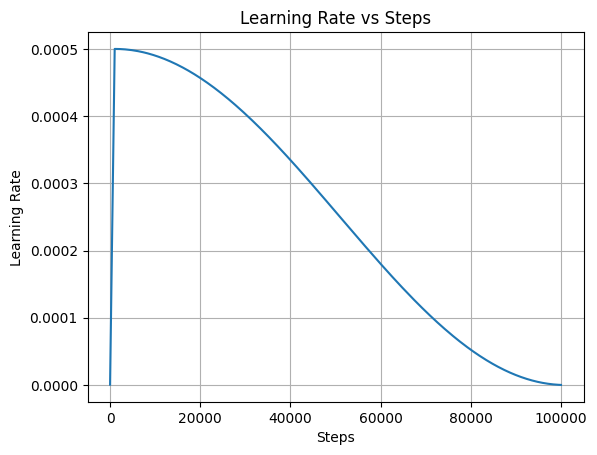

In [19]:
steps = jnp.arange(1, TArgs.num_steps+1)
lrs = jax.vmap(LearningRateSchedule(0).learning_rate)(steps)

plt.plot(steps, lrs); del lrs, steps
plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs Steps")
plt.show()

# Save and Load model

In [20]:
def save_object(dir_suffix_ftype:str, obj:Any):
    """
    dir_suffix_ftype: directory suffix and file type separated by "|"
    obj: Anything which is to be stored
    """
    dir, suffix, ftype = dir_suffix_ftype.split("|"); path = os.path.join(dir, "".join([suffix, f".{ftype}"]))
    os.makedirs(name=dir, exist_ok=True)
    with open(path, "wb") as file:
        pickle.dump(obj=obj, file=file, protocol=pickle.HIGHEST_PROTOCOL)
    return path

In [21]:
def load_object(path:str):
    with open(path, "rb") as file:
        obj = pickle.load(file)
    return obj

# Training

* Segregate trainable variables for building different optimizers
* Again combine them in the same order as it was (before segregating them) for `model.stateless_call`
* Segregate trainable variables for optimization of trainable variables for different optimizers

In [22]:
class ParamGradManager:
    def __init__(self, trainable_vars:list):
        order_before_segregate = [v.path for v in trainable_vars]
        order_after_segregate = (
            [v.path for v in trainable_vars if len(v.shape)!=1] +
            [v.path for v in trainable_vars if len(v.shape)==1]
        )
        self.idx = [order_after_segregate.index(b) for b in order_before_segregate]

    def filter_obj(self, trainable_obj:list):
        """can be grads or params"""
        decay_obj = [v for v in trainable_obj if len(v.shape)!=1]
        nodecay_obj = [v for v in trainable_obj if len(v.shape)==1]
        return decay_obj, nodecay_obj
    
    def combine_obj(self, decay_obj:list, nodecay_obj:list):
        obj = decay_obj + nodecay_obj
        return [obj[i] for i in self.idx]

In [23]:
start_iter = 0
if TArgs.resume_from_checkpoint is not None:
    best_ckpt = load_object(TArgs.resume_from_checkpoint)
    (
        trainable_vars,
        non_trainable_vars,
        (decay_opt_vars, nodecay_opt_vars),
        start_iter,
        best_val_loss,
        training_losses
    ) = best_ckpt
    for v, a in zip(model.trainable_variables, trainable_vars):
        v.assign(a)
    trainable_vars = model.trainable_variables
    param_grad_manager = ParamGradManager(trainable_vars)

In [24]:
learning_rate = LearningRateSchedule(start_iter=start_iter)
adamw = lambda weight_decay: nn.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=TArgs.beta1,
        beta_2=TArgs.beta2,
        clipnorm=TArgs.clipnorm,
        weight_decay=weight_decay
)
decay_optimizer = adamw(weight_decay=TArgs.weight_decay)
nodecay_optimizer = adamw(weight_decay=0.0)
loss_fn = nn.losses.SparseCategoricalCrossentropy(from_logits=True)

In [25]:
step = 0; wait = 0
if TArgs.resume_from_checkpoint is None:
    training_losses = {"train": []}
    trainable_vars = model.trainable_variables
    non_trainable_vars = model.non_trainable_variables
    
    param_grad_manager = ParamGradManager(trainable_vars)
    for param, opt in zip(param_grad_manager.filter_obj(trainable_vars), [decay_optimizer, nodecay_optimizer]):
        opt.build(param)
    
    decay_opt_vars, nodecay_opt_vars = decay_optimizer.variables, nodecay_optimizer.variables
    best_val_loss = 1e8
    
    best_ckpt = (
        trainable_vars,
        non_trainable_vars,
        (decay_opt_vars, nodecay_opt_vars),
        step,
        best_val_loss,
        training_losses
    )

In [26]:
@jax.jit
def get_accuracy(y_true:Array, logits:Array): # (B, T), (B, T, vocab_size)
    batched_num_correct = (logits.argmax(-1)==y_true).sum(-1)/y_true.shape[-1] # (B,)
    accuracy = batched_num_correct.mean()
    return accuracy

@jax.jit
def compute_loss(
        trainable_vars:list,
        non_trainable_vars:list,
        X_batch:Array, y_batch:Array,
        num_grad_accumalation_steps:int
    ):
    logits, non_trainable_vars = model.stateless_call(
        trainable_vars,  non_trainable_vars,
        X_batch)
    loss = loss_fn(y_batch, logits)
    accuracy = get_accuracy(y_batch, logits)
    unscaled_loss = loss/num_grad_accumalation_steps
    # scaled_loss = optimizer.scale_loss(unscaled_loss)
    return unscaled_loss, (unscaled_loss, accuracy, non_trainable_vars)
grad_fn = jax.value_and_grad(compute_loss, has_aux=True)

@partial(jax.jit, static_argnums=-1)
def mini_step(train_state:Sequence[list], X_batch:Array, y_batch:Array, num_grad_accumalation_steps:int):
    trainable_vars, non_trainable_vars = train_state

    (_, aux), grad = grad_fn(
        trainable_vars, non_trainable_vars, X_batch, y_batch,
        num_grad_accumalation_steps
    )
    (unscaled_loss, accuracy, non_trainable_vars) = aux
    return grad, (unscaled_loss, accuracy), (trainable_vars, non_trainable_vars)

def optimizer_apply(optimizer, opt_vars, grads, trainable_vars):
    trainable_vars, opt_vars = optimizer.stateless_apply(opt_vars, grads, trainable_vars)
    return trainable_vars, opt_vars

decay_opt_apply = jax.jit(fun=lambda opt_vars, grads, trainable_vars: optimizer_apply(
    decay_optimizer, opt_vars, grads, trainable_vars
))
nodecay_opt_apply = jax.jit(fun=lambda opt_vars, grads, trainable_vars: optimizer_apply(
    nodecay_optimizer, opt_vars, grads, trainable_vars
))

def update_params(
    grads:list,
    trainable_vars:list,
    optimizer_vars:tuple[list, list],
):
    decay_grads, nodecay_grads = param_grad_manager.filter_obj(grads)
    decay_trainable_vars, nodecay_trainable_vars = param_grad_manager.filter_obj(trainable_vars)
    decay_opt_vars, nodecay_opt_vars = optimizer_vars
    
    decay_trainable_vars, decay_opt_vars = decay_opt_apply(
        decay_opt_vars, decay_grads, decay_trainable_vars
    )
    nodecay_trainable_vars, nodecay_opt_vars = nodecay_opt_apply(
        nodecay_opt_vars, nodecay_grads, nodecay_trainable_vars
    )
    trainable_vars1 = param_grad_manager.combine_obj(decay_trainable_vars, nodecay_trainable_vars)
    assert (
        [v.shape for v in trainable_vars1] == 
        [v.shape for v in trainable_vars]), (
            f"train vars aft: {[v.shape for v in trainable_vars1]}\n\ntrain vars bef: {[v.shape for v in trainable_vars]}"
            )
    return trainable_vars1, (decay_opt_vars, nodecay_opt_vars)

def evaluate(train_state:Sequence[list]):
    trainable_vars, non_trainable_vars = train_state
    mean_losses = []; mean_accuracies = []
    for eval_batch_iter in [train_iterator, val_iterator]:
        X_batch, y_batch = next(eval_batch_iter)
        losses = jnp.empty(TArgs.eval_steps)
        accuracies = jnp.empty_like(losses)

        for eval_step in range(TArgs.eval_steps):
            _, (unscaled_loss, accuracy, non_trainable_vars) = compute_loss(
                trainable_vars, non_trainable_vars,
                jnp.array(X_batch), jnp.array(y_batch), 1
            )
            losses = losses.at[eval_step].set(unscaled_loss)
            accuracies = accuracies.at[eval_step].set(accuracy)
            X_batch, y_batch = next(eval_batch_iter)
        mean_losses.append(losses.mean())
        mean_accuracies.append(accuracies.mean())
    return mean_losses, mean_accuracies # ([train_loss, val_loss], [train_accuracy, val_accuracy])

In [ ]:
wait = 0
best_step = step

t0 = time.time()
print("Training about to start...")
X_batch, y_batch = next(train_iterator)
# TODO: Optimize Train Loop to reduce time per step
while True:
    # condition to terminate
    if step > TArgs.num_steps or wait > TArgs.patience:
        print(f"Early Stopping at Step {step}." if wait > TArgs.patience else "Training Terminated.")
        break
    
    # train model
    grads = jax.tree_util.tree_map(jnp.zeros_like, trainable_vars)
    for _ in range(TArgs.num_grad_accumalation_steps):
        grad, (loss, accuracy), (trainable_vars, non_trainable_vars) = mini_step(
            (trainable_vars, non_trainable_vars),
            jnp.array(X_batch), jnp.array(y_batch),
            TArgs.num_grad_accumalation_steps
        )
        grads = jax.tree_util.tree_map(
            lambda g1, g2: jnp.add(g1, g2), grads, grad
        ) # sum grads for grad accumation
        X_batch, y_batch = next(train_iterator)
    grad = None # save memory

    loss = loss*TArgs.num_grad_accumalation_steps # loss from last mini-step
    
    trainable_vars, (decay_opt_vars, nodecay_opt_vars) = update_params(
        grads, trainable_vars, (decay_opt_vars, nodecay_opt_vars)
    )
    grads = None # save memory

    if step % TArgs.eval_freq == 0 or step == TArgs.num_steps:
        print("Estimating Losses...")
        mean_losses, mean_accuracies = evaluate((trainable_vars, non_trainable_vars))
        print(
            f"\t| Training Loss: {mean_losses[0]:.4f} || Training Accuracy: {mean_accuracies[0]:.4f} |" 
            f"| Validation Loss: {mean_losses[1]:.4f} || Validation Accuracy: {mean_accuracies[1]:.4f} |"
        )
        
        _ = save_object(
            TArgs.checkpoint_dir+f"|checkpoint|gpt",
            obj=best_ckpt
        )
        print(f"Saved checkpoint of step {step}.")

        if mean_losses[1] < best_val_loss:
            best_val_loss = mean_losses[1]
            best_ckpt = (
                trainable_vars, 
                non_trainable_vars, 
                (decay_opt_vars, nodecay_opt_vars),
                step,
                best_val_loss
            )
            best_step = step
            wait = 0
        else:
            wait += 1

    # time
    t1 = time.time()
    dt = t1-t0; t0 = t1

    # print the essentials
    print(
        f"| Step: {step} || Loss: {loss:.4f} || Accuracy: {accuracy:.4f} |"
        f"| LR: {learning_rate(step):e} || dt: {dt*1000:.2f}ms |"
    )
    training_losses["train"].append(loss.tolist())
    step += 1

train_state = (trainable_vars, non_trainable_vars)
if TArgs.return_best_train_states:
    print(f"Best Weights are from Step {best_step}")
    print("With an Estimated Validation Loss of", best_val_loss)
    train_state = best_ckpt[:2] 
# clear cell output, too large

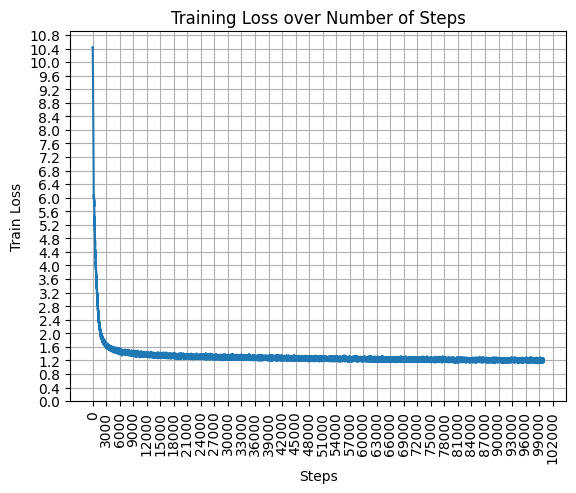

In [28]:
plt.plot(training_losses["train"])
plt.title("Training Loss over Number of Steps")
plt.xlabel("Steps")
plt.ylabel("Train Loss")
plt.xticks(range(0, TArgs.num_steps+3_000, 3_000), rotation=90)
plt.yticks(jnp.arange(0, 11, 0.4).tolist())
plt.grid(True)
plt.show()

## karpathy's llama2 logs
# 200: 5.54
# 600: 2.34
# 1st eval: train: 1.47 val: 1.47
# 2400: 1.48
# 3226 | loss 1.3816 | lr 4.993765e-04 | 260.28ms | mfu 15.25%

# NOTE: This model takes ~490ms per step, have to optimize it (maybe because of the gradient accumulation loop).

In [41]:
save_object(
    TArgs.checkpoint_dir+f"|train_state_15M|gpt",
    obj=train_state
)

'ckpt/stories32000/train_state.gpt'

# Sampling from model

In [29]:
class GenerateTokens:
    def __init__(self, model:nn.Model, train_state:Sequence[list], maxlen:int, sos:int):
        self.SOS = jnp.array([[sos]])
        self.model = model
        self.train_state = train_state
        self.maxlen = maxlen
    
    @staticmethod
    @jax.jit
    def randCategorical(key:Array, logits:Array):
        idx_next = jrand.categorical(key, logits)[..., None]
        return idx_next # (1, 1)

    @staticmethod
    # TODO(VachanVY): Debug when jitted
    # @partial(jax.jit, static_argnums=-1)
    def topK(key:Array, logits:Array, k:Array):
        if jnp.where(k==1, True, False):
            idx_next = logits.argmax(-1, keepdims=True)
            return idx_next
        logits, topK_idx = jax.lax.top_k(logits, k=k)
        idx = jrand.categorical(key, logits)
        idx_next = topK_idx[0][idx][..., None]
        return idx_next # (1, 1)

    @staticmethod
    # TODO(VachanVY): Debug when jitted
    # @partial(jax.jit, static_argnums=(-1, -2))
    def topP(key:Array, logits:Array, p:float, k:int|None=None):
        probs = jax.nn.softmax(logits, axis=-1)
        # reverse arg sort of probs
        rev_argsort_prob_idx = jnp.argsort(probs)[:, ::-1]
        # True bools of idx less than p that sum less than p || False bool of least idxs that sum more than p
        less_than_p_bools = (jnp.cumsum(probs.take(rev_argsort_prob_idx), axis=-1) <= p)
        
        # idx from which to mask
        mask_from_id = less_than_p_bools.sum()+1
        # idxs to mask
        mask_idx = rev_argsort_prob_idx[:, mask_from_id:]
        # -inf masked idx won't be sampled
        logits = logits.at[:, mask_idx].set(-jnp.inf)
        
        if k is not None:
            key, _ = jrand.split(key)
            idx_next = GenerateTokens.topK(key, logits, k)
            return idx_next # (1, 1)
        
        idx_next = jrand.categorical(key, logits)[..., None]
        return idx_next # (1, 1)

    @partial(jax.jit, static_argnums=0)
    def get_logits(self, idx_cond:Array, trainable_variables:list, non_trainable_variables:list):
        logits, non_trainable_variables = self.model.stateless_call(
            trainable_variables, non_trainable_variables, idx_cond
        )
        return logits[:, -1, :], non_trainable_variables

    def generate(self, idx:Array, max_tok:int=500, top_k:int|None=None, top_p:float|None=None,  temp:float=0.8, seed:int=42):
        trainable_variables, non_trainable_variables = self.train_state
        if (not top_k) and (not top_p):
            sampleTok:Callable[[Array, Array], Array] = GenerateTokens.randCategorical
        elif (top_k is not None) and (top_p is not None):
            sampleTok:Callable[[Array, Array], Array] = lambda key, logits: GenerateTokens.topP(key, logits, top_p, top_k)
        elif top_k is not None:
            sampleTok:Callable[[Array, Array], Array] = lambda key, logits: GenerateTokens.topK(key, logits, top_k)
        elif top_p is not None:
            sampleTok:Callable[[Array, Array], Array] = lambda key, logits: GenerateTokens.topP(key, logits, top_p)
        else:
            assert False, "(?_?) ¯\(°_o)/¯"
        
        key = jrand.PRNGKey(seed)
        for _ in range(max_tok):
            idx_cond = idx[:, -self.maxlen:] # (B=1, T)
            logits, non_trainable_variables = self.get_logits(
                idx_cond, trainable_variables, non_trainable_variables
            ) # (B, vocab_size)
            idx_next = sampleTok(key, logits/temp) # (1, 1)
            if idx_next == self.SOS:
                break
            key, _ = jrand.split(key)
            idx = jnp.concatenate((idx, idx_next), axis=-1) # (B=1, T+1)
        return idx[0].tolist()

sampler = GenerateTokens(model, train_state, GPTConfig.maxlen, sos=SOS)

In [30]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode("Once upon a time,")]), top_k=1))) # ~?mins

Once upon a time, there was a little girl named Lily. She loved to play with her toys and eat yummy food. One day, she found a big, round thing in her room. It was a microscope. Lily was very curious about it.
Lily wanted to see what was inside the microscope. She tried to open it, but it was very hard. She tried and tried, but she could not open it. Lily felt sad and wanted to find a way to open the microscope.
Then, Lily had an idea. She asked her mom for help. Her mom showed her how to open the microscope. Lily was so happy! She looked through the microscope and saw many tiny things. She was so excited to see the tiny things. Lily and her mom had a fun day together.


In [31]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode("Once upon a time,")]), top_p=0.9))) # ~?mins

Once upon a time, there was a little boy named Tim. Tim loved to go to the gym with his mom. The gym was very big and had many fun things to do. Tim's mom was very reliable and always made sure he had a safe way to go.
One day, Tim saw a big ball in the gym. He wanted to play with it, but he knew he had to wait for his turn. So, Tim's mom told him not to go into the gym when he was little. Tim said, "Okay, Mom. I will wait."
Tim played with his ball all day. He had so much fun at the gym. But then, the ball went into the gym and got stuck in a big puddle. Tim tried to get the ball out, but he could not. He was sad.
Then, Tim's mom came to help him. She told him, "It's okay, Tim. You can still have fun at the gym." Tim smiled and learned that it was okay to be excited, but it was also okay. He knew that waiting could lead to fun surprises.


In [32]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode("Once upon a time,")]), top_p=0.9, seed=3232323))) # ~?mins

Once upon a time, there was a little girl named Sue. Sue had a toy box that she loved. The toy box was big and pretty. Sue liked to play with her toys every day.
One day, Sue's mom said, "Sue, we have to leave for a week." Sue was sad, but she knew her mom was right. So, they put her toy box away and went to the store. Sue saw a toy she liked, but she could not have it.
Sue's mom saw her sad face and said, "Don't worry, Sue. We will return this toy to you later." Sue smiled and hugged her mom. They left the store, and Sue played with her toy box all the way home.


In [33]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode("Once upon a time,")]), top_p=0.9, seed=3432))) # ~?mins

Once upon a time, there was a little boy named Tim. Tim loved to play outside with his friends. One day, Tim saw a big, round thing in the sky. It was a comet! The comet was very fast and it made Tim very happy.
Tim wanted to show his friends the comet. He tried to lift the comet up high. But the comet was too big and heavy. Tim felt helpless. He did not know what to do. He wanted to show his friends the comet, but he could not lift it.
Tim's mom saw him and came to help. She showed Tim how to lift the comet together. Tim was so happy! He learned how to lift the comet and they played together. They were both very happy.


In [34]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode("Once upon a time,")]), top_p=0.9, seed=342456))) # ~?mins

Once upon a time, there was a little girl named Mia. Mia had a pretty jacket with a big pocket. One day, Mia was very hungry. She wanted to eat a sandwich. Mia looked in her pocket and saw a big, yummy sandwich. But the sandwich was not there. Mia was sad.
Mia's mom saw her sad face and asked, "Why are you sad, Mia?" Mia showed her mom the sandwich she found in the sandwich. Her mom smiled and said, "Don't worry, Mia. I have a surprise for you." Mia's mom gave her a big, yummy sandwich. Mia was very happy.
Mia went back to her mom and said, "Thank you, mom!" Her mom said, "You're welcome, Mia. I'm glad you like it!" Mia smiled and ate her sandwich. She was not hungry anymore. From that day on, Mia always remembered to check her pocket for sandwiches.


In [35]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode(
    "Once upon a time there was a little girl named Lucy. She loved to go to the store to buy sweets with her mom and dad"
    )]), seed=13213, top_p=0.9))) # ~?mins

Once upon a time there was a little girl named Lucy. She loved to go to the store to buy sweets with her mom and dad.
One day, when Lucy and her parents went to the store, they saw a big, delicious cake. Lucy's mom said, "Let's buy some cake, but we must delay. We need to get ready for the party tonight."
So they all waited and waited, and then they went to the cake. But when they got there, they found out the cake was a surprise for them! Lucy and her family laughed and enjoyed the delicious cake together.


In [36]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode(
    "Once upon a time, in a big forest, there was a fearful little dog named Spot")]), top_k=50, seed=3298486))
) # ~?mins

Once upon a time, in a big forest, there was a fearful little dog named Spot. Spot was always scared of the dark, loud sounds outside. One day, while Spot was playing near the trees, he heard a loud sound. It was a big, scary cat! Spot was so scared, he ran away fast.
Spot tried to hide, but the big, scary cat found him. The cat did not want to hurt Spot, so it chased him. Spot ran and ran, but he could not get away. He was very sad and scared.
Then, something unexpected happened. The big, scary cat found a magic rock. The rock could make the cat stop. The cat turned into a big, strong monster. The monster took Spot away, and he was never seen again. Spot was very sad and scared of the big, scary cat.


In [37]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode(
    "Once upon a time, in a big forest, there was a fearful little dog named Spot")]), top_k=1, seed=3298486))
) # ~?mins

Once upon a time, in a big forest, there was a fearful little dog named Spot. Spot was scared of everything. One day, Spot saw a big tree with a small bird on it. The bird was sad because it could not fly.
Spot wanted to help the bird. He thought of a plan. Spot would use his paw to push the bird up to the tree. He used his paw to push the bird up to the tree. The bird was happy and said, "Thank you, Spot!"
The bird was not fearful anymore. It was happy to have a friend. Spot and the bird played together in the forest. They were the best of friends. And they lived happily ever after.


In [38]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode(
    "Once upon a time, in a big forest, there was a fearful little dog named Spot")]), top_p=0.9, seed=3298486))
) # ~?mins

Once upon a time, in a big forest, there was a fearful little dog named Spot. Spot was scared of everything. One day, Spot went for a walk with his best friend, a tiny bird named Tweet.
As they walked, they saw a big tree with a red ball stuck in it. Spot wanted to get the ball, but he was too small to reach it. Tweet tried to help Spot, but he was too small. They needed to find a way to get the ball down.
Then, Spot had an idea. He would jump and bark very loud. Tweet said, "I will fly up and push the ball, and it will fall!" So, Tweet flew up to the tree and pushed the red ball with his beak. The ball fell down, and Spot was happy.
Spot and Tweet played with the red ball all day. They had lots of fun, and Spot was not scared anymore. They knew that being friends was not bad, but being together was important. And from that day on, Spot was never fearful of anything again.


In [39]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode(
    "One day,")]), top_p=0.9, seed=23232326567))
) # ~?mins

One day, a little boy named Tim went to the park. He saw a big, dark cloud in the sky. Tim was not scared, but he kept looking at the cloud.
Then, Tim saw a small bird on the ground. The bird was hurt and could not fly. Tim wanted to help the bird, so he took it to his mom. His mom said, "We will help the bird, but we must be careful."
Tim's mom got a bandage and put it on the bird's wing. The bird felt better and started to fly again. The bird said, "Thank you, Tim and mom!" Tim and his mom were happy they could help the bird.


In [40]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode(
    "One day, Lily met a Shoggoth")]), top_p=0.9, seed=3298486))
) # ~?mins

One day, Lily met a Shoggoth. They were very good friends. The Shogg's name was Shelly. They liked to play and have fun together.
One day, Lily and Shelly were playing near the water. Shelly swimming fast, but he was scared. He started to tremble. Lily saw Shelly and said, "Shelly, let's go back to the water. It will be safe there."
Shelly felt better. He stopped trembling. He went back to Lily and they played together. Shelly was happy to have a new friend. They went back to the water to play more games.


```python
before = ["a", "b", "c", "d"]
after = ["c", "b", "d", "a"]

indices = [after.index(b) for b in before]
print(indices)
rearranged_after = [after[i] for i in indices]
print(rearranged_after)
```